#Environment Setup

In [ ]:
!git clone https://github.com/phantomcorn/artemis
!git clone https://github.com/phantomcorn/open-musiclm.git
%cd artemis
!pip3 install -e .
%cd ..
%cd open-musiclm
!pip install -e .
%cd ..

Cloning into 'artemis'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 244 (delta 4), reused 7 (delta 2), pack-reused 231
Receiving objects: 100% (244/244), 99.43 MiB | 30.06 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Cloning into 'open-musiclm'...
remote: Enumerating objects: 1333, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 1333 (delta 273), reused 233 (delta 233), pack-reused 1027
Receiving objects: 100% (1333/1333), 1.81 MiB | 5.41 MiB/s, done.
Resolving deltas: 100% (936/936), done.
/content/artemis
Obtaining file:///content/artemis
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 15.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x8

In [ ]:
%cd artemis
from PIL import Image
import torch
import json
import numpy as np
import random

from artemis.in_out.basics import pickle_data
from artemis.in_out.arguments import parse_test_speaker_arguments
from artemis.in_out.neural_net_oriented import torch_load_model, load_saved_speaker, seed_torch_code
from artemis.neural_models.attentive_decoder import negative_log_likelihood
from artemis.captioning.sample_captions import versatile_caption_sampler, captions_as_dataframe
from artemis.in_out.datasets import sub_index_affective_dataloader
from artemis.in_out.datasets import default_grounding_dataset_from_affective_loader
from artemis.in_out.datasets import custom_grounding_dataset_similar_to_affective_loader

import pandas as pd
from artemis.in_out.basics import unpickle_data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%cd ..
#------------------------------------------------------------------------------#
%cd open-musiclm
import os
import sys


import torchaudio
from einops import rearrange
import argparse
from pathlib import Path
from dataclasses import asdict, dataclass

from open_musiclm.laion_clap import CLAP_Module
from open_musiclm.config import load_model_config, create_musiclm_from_config
from open_musiclm.clap_quantized import ClapQuantized, create_clap_quantized
from open_musiclm.encodec_wrapper import EncodecWrapper, create_encodec_24khz
from open_musiclm.hf_hubert_kmeans import HfHubertWithKmeans, get_hubert_kmeans
from open_musiclm.open_musiclm import (MusicLM, TokenConditionedTransformer,
                           create_coarse_transformer, create_fine_transformer,
                           create_semantic_transformer)
import torch.nn as nn
import torch.nn.functional as F
%cd ..
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/content/artemis


/content/artemis/artemis/in_out/datasets.py:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if img.mode is not 'RGB':
/content/artemis/artemis/in_out/datasets.py:69: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.rgb_only and img.mode is not 'RGB':


/content
/content/open-musiclm
/content


In [ ]:
def seed_torch_code(seed, strict=False):
    """Control pseudo-randomness for reproducibility.
    :param manual_seed: (int) random-seed
    :param strict: (boolean) if True, cudnn operates in a deterministic manner
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if strict:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed = 42
seed_torch_code(seed)

In [ ]:
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/Project"

#Image-Text

##Build sample dataset from image-music pair

In [ ]:
df = pd.read_csv(f'{PROJECT_PATH}/new_dataset/random_similar_subsample.csv', delimiter=",")
df

,WAV_FILE,IMG_FILE,score,euclid_dist,img_from_folder
0,2050-99,COCO_train2014_000000437816,0.481734,0.116003,emotic/mscoco
1,456-18,Landscapes_007_h,0.967787,0.748898,naps
2,2018-15,COCO_train2014_000000334162,0.456108,0.320120,emotic/mscoco
3,1179-20,COCO_train2014_000000372180,0.391331,0.680655,emotic/mscoco
4,459-17,1ur587hhql42nei76a,0.369585,0.315536,emotic/emodb_small
5,368-13,frame_4z9ex8xqcl2trcn0,0.878508,0.239056,emotic/framesdb
6,1870-10,COCO_val2014_000000156324,0.334661,0.123327,emotic/mscoco
7,605-16,COCO_val2014_000000267537,0.975876,0.282321,emotic/mscoco
8,1763-9,COCO_train2014_000000167795,0.893219,0.209336,emotic/mscoco
9,2027-28,COCO_val2014_000000558294,0.934837,0.055722,emotic/mscoco


In [ ]:
art_style = []
painting = []
emotion = []
utterance = []
repetition = []
split = []
tokens = []
tokens_len = []
utterance_spelled = []
tokens_encoded = []
emotion_label = []


for sample in df.iterrows():
  img_fname = sample[1].IMG_FILE
  img_subdir = f'{sample[1].img_from_folder}/images'
  img_path = f'{PROJECT_PATH}/IMEMNet/{img_subdir}/{img_fname}.jpg'
  img = Image.open(img_path).convert('RGB')

  save_path = f'{PROJECT_PATH}/Artemis/wikiart/Sample/{img_fname}.jpg'
  if not os.path.exists(save_path): #save to Artemis folder if not exist (location used for captioning)
    img.save(save_path)

  art_style.append("Sample")
  painting.append(img_fname)
  split.append("test")
  emotion.append("something else") #placeholder
  utterance.append("TEST") #placeholder
  repetition.append(1) #placeholder
  tokens.append(["TEST"]) #placeholder
  tokens_len.append(1)    #placeholder
  utterance_spelled.append("test") #placeholder
  tokens_encoded.append([0]) #placeholder
  emotion_label.append(1) #placeholder

In [ ]:
records = {"art_style": art_style,
           "painting": painting,
           "emotion": emotion,
           "utterance": utterance,
           "repetition": repetition,
           "split": split,
           "tokens": tokens,
           "tokens_len": tokens_len,
           "utterance_spelled": utterance_spelled,
           "tokens_encoded": tokens_encoded,
           "emotion_label": emotion_label}
artemis_subsample_df = pd.DataFrame(records)
print(artemis_subsample_df.head())
artemis_subsample_df.to_csv(f'{PROJECT_PATH}/Artemis/preprocessed_data/for_model/artemis_preprocessed.csv')

  art_style                     painting         emotion utterance  \
0    Sample  COCO_train2014_000000437816  something else      TEST   
1    Sample             Landscapes_007_h  something else      TEST   
2    Sample  COCO_train2014_000000334162  something else      TEST   
3    Sample  COCO_train2014_000000372180  something else      TEST   
4    Sample           1ur587hhql42nei76a  something else      TEST   

   repetition split  tokens  tokens_len utterance_spelled tokens_encoded  \
0           1  test  [TEST]           1              test            [0]   
1           1  test  [TEST]           1              test            [0]   
2           1  test  [TEST]           1              test            [0]   
3           1  test  [TEST]           1              test            [0]   
4           1  test  [TEST]           1              test            [0]   

   emotion_label  
0              1  
1              1  
2              1  
3              1  
4              1  


## Image Captioning

In [ ]:
ARTEMIS_MODEL_PATH="/content/drive/MyDrive/Colab Notebooks/Project/Artemis/models/vanilla_SAT_speaker"
SPEAKER_SAVED_ARGS = ARTEMIS_MODEL_PATH + "/config.json.txt"
SPEAKER_CHECKPOINT = ARTEMIS_MODEL_PATH + "/checkpoints/best_model.pt"
SPLIT = "test"
MAX_UTTERANCE_LEN = 15
OUT_PATH="/content/drive/MyDrive/Colab Notebooks/Project/Artemis/inference/output/output.pkl"
SUBSAMPLE_DATA = -1 #if not -1, will subsample the underlying dataset and will annotated only this many images.
CUSTOM_DATA_CSV = None #if you want to annotate your own set of images e.g. adding manual emotional grounding. See code for what this csv should look like.
COMPUTE_NLL = False
SAMPLING_CONFIG_FILE = "/content/artemis/artemis/data/speaker_sampling_configs/selected_hyper_params.json.txt"
IMG2EMO_CHECKPOINT = None
N_WORKERS = None

In [ ]:
# Load pretrained speaker & its corresponding train-val-test data. If you do not provide a
# custom set of images to annotate. Then based on the -split you designated it will annotate this data.
speaker, epoch, data_loaders = load_saved_speaker(SPEAKER_SAVED_ARGS, SPEAKER_CHECKPOINT,
                                                  with_data=True, verbose=True)
speaker = speaker.to(device)
eos = speaker.decoder.vocab.eos
working_data_loader = data_loaders[SPLIT]

if MAX_UTTERANCE_LEN is None:
    # use the maximum length in the underlying split.
    def utterance_len(tokens, eos=eos):
        return np.where(np.asarray(tokens) == eos)[0][0] -1 # -1 to remove sos
    MAX_UTTERANCE_LEN = working_data_loader.dataset.tokens.apply(utterance_len).max()

use_custom_dataset = False
if CUSTOM_DATA_CSV is not None:
    use_custom_dataset = True

if COMPUTE_NLL and not use_custom_dataset:
    print('Computing Negative Log Likelihood of ground-truth annotations:')
    nll = negative_log_likelihood(speaker, working_data_loader, device)
    print('{} NLL: {}'.format(SPLIT, nll))

img2emo_clf = None
if IMG2EMO_CHECKPOINT:
    img2emo_clf = torch_load_model(IMG2EMO_CHECKPOINT, map_location=device)

if use_custom_dataset:
    annotate_loader = custom_grounding_dataset_similar_to_affective_loader(CUSTOM_DATA_CSV,
                                                                            working_data_loader, N_WORKERS)
else:
    # removes duplicate images and optionally uses img2emo_clf to create a grounding emotion.
    annotate_loader = default_grounding_dataset_from_affective_loader(working_data_loader, img2emo_clf,
                                                                      device, N_WORKERS)

if SUBSAMPLE_DATA != -1:
    sids = np.random.choice(len(annotate_loader.dataset.image_files), SUBSAMPLE_DATA)
    annotate_loader = sub_index_affective_dataloader(annotate_loader, sids)

with open(SAMPLING_CONFIG_FILE) as fin:
    sampling_configs = json.load(fin)

print('Loaded {} sampling configurations to try.'.format(len(sampling_configs)))
optional_params = {'max_utterance_len': MAX_UTTERANCE_LEN, 'drop_unk': True, 'drop_bigrams': True}

final_results = []
for config in sampling_configs:
    for param in optional_params.keys():
        if param not in config:
          config[param] = optional_params[param]
    print('Sampling with configuration: ', config)

    captions_predicted, attn_weights = versatile_caption_sampler(speaker, annotate_loader, device, **config)
    df = captions_as_dataframe(annotate_loader.dataset, captions_predicted, wiki_art_data=not use_custom_dataset)
    final_results.append([config, df])
    print('Done.')

pickle_data(OUT_PATH, final_results)
print(captions_predicted)


Loading saved speaker trained with parameters:
{'atn_cover_img_alpha': 1,
 'atn_spatial_img_size': None,
 'attention_dim': 512,
 'batch_size': 128,
 'data_dir': '/content/drive/MyDrive/Colab '
             'Notebooks/Project/Artemis/preprocessed_data/for_model',
 'dataset': 'artemis',
 'debug': False,
 'decoder_lr': 0.0005,
 'dropout_rate': 0.1,
 'emo_grounding_dims': [9, 9],
 'encoder_lr': 0.0001,
 'fine_tune_data': None,
 'gpu': '1',
 'img_dim': 256,
 'img_dir': '/content/drive/MyDrive/Colab Notebooks/Project/Artemis/wikiart',
 'lanczos': True,
 'log_dir': '/content/drive/MyDrive/Colab '
            'Notebooks/Project/Artemis/models/vanilla_SAT_speaker',
 'lr_patience': 2,
 'max_train_epochs': 50,
 'num_workers': 10,
 'random_seed': 2021,
 'resume_path': None,
 'rnn_hidden_dim': 512,
 'save_each_epoch': False,
 'teacher_forcing_ratio': 1,
 'train_patience': 5,
 'use_emo_grounding': False,
 'use_timestamp': True,
 'vis_encoder': 'resnet34',
 'word_embedding_dim': 128}
Using a vocabula

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the w

Loading speaker model at epoch 7.
Loaded 50 utterances
Loaded 1 sampling configurations to try.
Sampling with configuration:  {'sampling_rule': 'beam', 'temperature': 0.3, 'beam_size': 5, 'max_utterance_len': 15, 'drop_unk': True, 'drop_bigrams': True}


  0%|          | 0/50 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 50/50 [00:29<00:00,  1.71it/s]

Done.
["the woman 's face is very expressive and the colors are soft and gentle", 'the snake looks like it is flying in the air', 'the cat looks like he is about to be attacked by the bird', 'the person in the painting looks like they are having a good time', 'the woman looks like she is working hard and has a hard life', 'the people in the painting look like they are having a good time', 'the man is looking at the viewer with a sense of wonder', 'the painting is very colorful and the colors are very vibrant', 'the painting is very colorful and the colors are bright and cheerful', 'the pigs look like they are having a good time', 'the man looks like he is about to be attacked by the wind', "the man is trying to get the woman 's advances", 'the man in the middle looks like he is in deep thought', 'the man is carrying a gun and is trying to get the weight of the world', 'the man is sitting in a chair with a stick', 'the man in the doorway looks like he is about to be executed', 'the man 

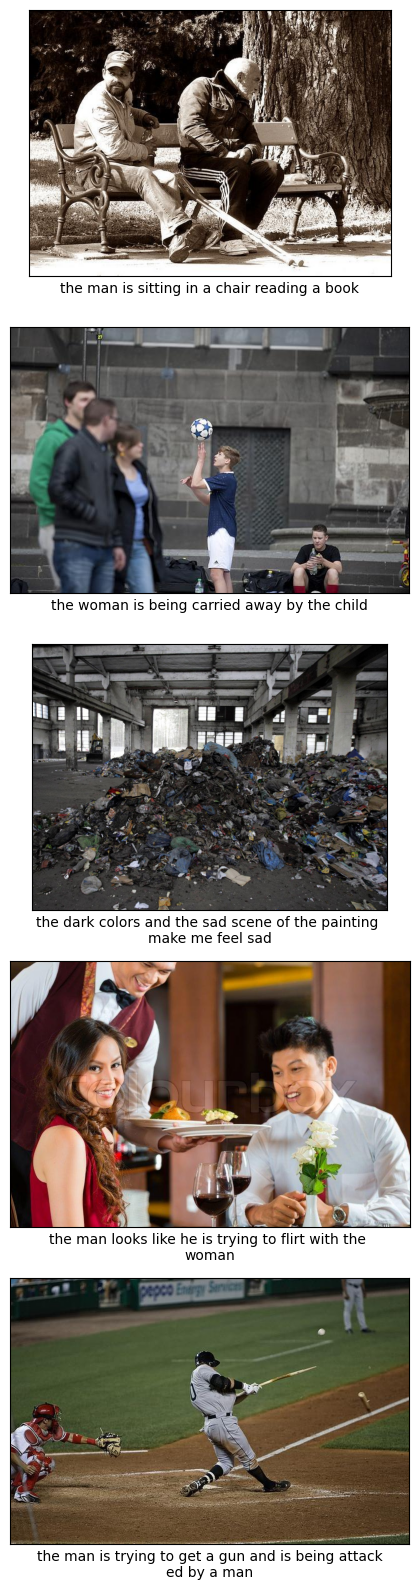

In [ ]:
num_to_show = 5

output_file = "/content/drive/MyDrive/Colab Notebooks/Project/Artemis/inference/output/output.pkl"
data = unpickle_data(output_file)
df = next(data)[0][1]

# df.to_csv(f'{PROJECT_PATH}/new_dataset/random_similar_caption.csv', index=False) #Save

fig, ax = plt.subplots(num_to_show,figsize=(16, 16))
line_break = 50
for i,sample in enumerate(df.sample(num_to_show).iterrows()):
  img_path = f'/content/drive/MyDrive/Colab Notebooks/Project/Artemis/wikiart/Sample/{sample[1].painting}.jpg'

  caption = sample[1].caption
  caption = '\n'.join([caption[i:i+line_break] for i in range(0, len(caption), line_break)]) #add line breaks

  img = mpimg.imread(img_path)
  ax[i].imshow(img)
  ax[i].set_yticks([])
  ax[i].set_xticks([])


  ax[i].set_xlabel(caption)
  # plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)
fig.tight_layout()





#Text-Sound

In [ ]:
df = pd.read_csv(f'{PROJECT_PATH}/new_dataset/random_similar_caption.csv')

already_generated_fnames = os.listdir(f'{PROJECT_PATH}/new_dataset/random_similar_output')
already_generated_fnames = list(map(lambda fnames: fnames.split(".")[0], already_generated_fnames))
df = df[~df.painting.isin(already_generated_fnames)]
df

,art_style,painting,grounding_emotion,caption
1,Sample,Animals_035_h,NaN,the snake looks like it is flying in the air
2,Sample,Animals_158_h,NaN,the cat looks like he is about to be attacked ...
3,Sample,COCO_train2014_000000070788,NaN,the person in the painting looks like they are...
4,Sample,COCO_train2014_000000098596,NaN,the woman looks like she is working hard and h...
5,Sample,COCO_train2014_000000167795,NaN,the people in the painting look like they are ...
6,Sample,COCO_train2014_000000212303,NaN,the man is looking at the viewer with a sense ...
7,Sample,COCO_train2014_000000242582,NaN,the painting is very colorful and the colors a...
8,Sample,COCO_train2014_000000251113,NaN,the painting is very colorful and the colors a...
9,Sample,COCO_train2014_000000257301,NaN,the pigs look like they are having a good time
10,Sample,COCO_train2014_000000293383,NaN,the man looks like he is about to be attacked ...


In [ ]:
class disable_print:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def load_model(model, path):
    """helper class to load a model checkpoint"""
    path = Path(path)
    assert path.exists(), f'checkpoint does not exist at {str(path)}'
    pkg = torch.load(str(path))
    model.load_state_dict(pkg)



MUSICLM_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/Open-MusicLM/"
MUSICLM_MODEL_PATH = MUSICLM_PATH + "musiclm_large_small_context.json"
SEMANTIC_PATH = MUSICLM_PATH + "semantic.transformer.14000.pt"
COARSE_PATH = MUSICLM_PATH + "coarse.transformer.18000.pt"
FINE_PATH = MUSICLM_PATH + "fine.transformer.24000.pt"
CLAP_PATH = MUSICLM_PATH  + "630k-audioset-best-modified.pt" #"music_audioset_epoch_15_esc_90.14.pt"
RVQ_PATH = MUSICLM_PATH + "clap.rvq.950_no_fusion.pt"
KMEANS_PATH = MUSICLM_PATH + "kmeans_10s_no_fusion.joblib"

model_config = load_model_config(MUSICLM_MODEL_PATH)
model_config

In [ ]:
#For loading bigger model: load model 'HTSAT-base'
# music_speech_audioset_epoch_15_esc_89.98.pt
# music_audioset_epoch_15_esc_90.14.pt
# music_speech_epoch_15_esc_89.25.pt

# with disable_print():
#   clap = CLAP_Module(enable_fusion=False, amodel='HTSAT-base', device=device)
#   clap.load_ckpt(CLAP_PATH)

# clap_quantized = ClapQuantized(clap=clap, learn_rvq=False)
# rvq = torch.load(RVQ_PATH, map_location=device)
# clap_quantized.rq.load_state_dict(rvq)
# clap_quantized

#For loading smaller model: load model 'HTSAT-tiny' with other configs
#  630k-audioset-best.pt or 630k-audioset-fusion-best.pt (non-fusion/fusion)
clap_quantized = create_clap_quantized(**asdict(model_config.clap_rvq_cfg),
            device=device,
            learn_rvq=False,
            rvq_checkpoint_path=RVQ_PATH,
        ).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Load our best checkpoint in the paper.
Download completed!
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm2.weight 	 Loaded
aud

In [ ]:
wav2vec = get_hubert_kmeans(
        **asdict(model_config.hubert_kmeans_cfg),
        kmeans_path=KMEANS_PATH
    ).to(device)

config.json:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

You are using a model of type mert_model to instantiate a model of type hubert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of HubertModel were not initialized from the model checkpoint at m-a-p/MERT-v0 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MiniBatchKMeans from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
encodec_wrapper = create_encodec_24khz(**asdict(model_config.encodec_cfg)).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Downloading: "https://dl.fbaipublicfiles.com/encodec/v0/encodec_24khz-d7cc33bc.th" to /root/.cache/torch/hub/checkpoints/encodec_24khz-d7cc33bc.th
100%|██████████| 88.9M/88.9M [00:01<00:00, 90.5MB/s]


In [ ]:
semantic_transformer = create_semantic_transformer(
      **asdict(model_config.semantic_cfg),
      clap_codebook_size=model_config.clap_rvq_cfg.codebook_size,
      semantic_codebook_size=model_config.hubert_kmeans_cfg.codebook_size,
      num_clap_quantizers=model_config.clap_rvq_cfg.rq_num_quantizers
    ).to(device)

load_model(semantic_transformer, SEMANTIC_PATH)

In [ ]:
coarse_transformer = create_coarse_transformer(
        **asdict(model_config.coarse_cfg),
        clap_codebook_size=model_config.clap_rvq_cfg.codebook_size,
        semantic_codebook_size=model_config.hubert_kmeans_cfg.codebook_size,
        acoustic_codebook_size=model_config.encodec_cfg.codebook_size,
        num_clap_quantizers=model_config.clap_rvq_cfg.rq_num_quantizers,
        num_coarse_quantizers=model_config.global_cfg.num_coarse_quantizers,
    ).to(device)

load_model(coarse_transformer, COARSE_PATH)

In [ ]:
fine_transformer = create_fine_transformer(
        **asdict(model_config.fine_cfg),
        clap_codebook_size=model_config.clap_rvq_cfg.codebook_size,
        acoustic_codebook_size=model_config.encodec_cfg.codebook_size,
        num_clap_quantizers=model_config.clap_rvq_cfg.rq_num_quantizers,
        num_coarse_quantizers=model_config.global_cfg.num_coarse_quantizers,
        num_fine_quantizers=model_config.global_cfg.num_fine_quantizers
    ).to(device)

load_model(fine_transformer, FINE_PATH)

In [ ]:
musiclm = MusicLM(
        wav2vec=wav2vec,
        clap=clap_quantized,
        neural_codec=encodec_wrapper,
        semantic_transformer=semantic_transformer,
        coarse_transformer=coarse_transformer,
        fine_transformer=fine_transformer
    ).to(device)

In [ ]:
duration = 8
return_coarse_wave = True
for row in df.iterrows():
  generated_wave = musiclm.forward(
              text=row[1].caption,
              output_seconds=duration,
              semantic_window_seconds=model_config.global_cfg.semantic_audio_length_seconds,
              coarse_window_seconds=model_config.global_cfg.coarse_audio_length_seconds,
              fine_window_seconds=model_config.global_cfg.fine_audio_length_seconds,
              semantic_steps_per_second=model_config.hubert_kmeans_cfg.output_hz,
              acoustic_steps_per_second=model_config.encodec_cfg.output_hz,
              return_coarse_generated_wave=return_coarse_wave,
          ).detach().cpu()

  # print(generated_wave.shape)
  # generated_wave = rearrange(generated_wave, 'b n -> b 1 n')
  torchaudio.save(f'{PROJECT_PATH}/new_dataset/random_similar_output/{row[1].painting}.wav', generated_wave, musiclm.neural_codec.sample_rate)
  print(f'{row[1].painting}.wav saved!')

generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


Animals_035_h.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


Animals_158_h.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000070788.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000098596.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000167795.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


COCO_train2014_000000212303.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


COCO_train2014_000000242582.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000251113.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000257301.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000293383.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000305485.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


COCO_train2014_000000328314.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000333920.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


COCO_train2014_000000334059.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000334162.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000372180.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000405520.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000437816.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000458172.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


COCO_train2014_000000467182.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000489958.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


COCO_train2014_000000518052.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000522758.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_train2014_000000547509.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


COCO_train2014_000000559107.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_val2014_000000027570.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


COCO_val2014_000000156324.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_val2014_000000179960.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_val2014_000000233521.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_val2014_000000238410.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


COCO_val2014_000000267537.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_val2014_000000479633.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


COCO_val2014_000000523230.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


COCO_val2014_000000558294.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


Faces_287_h.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


Landscapes_004_h.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


Landscapes_007_h.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


Landscapes_015_h.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


Landscapes_175_h.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


dsoxvx1zeyio30cqq1.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


fom5k1l9flmfcdjmm9.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


frame_10qb62s8d60g8bib.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


frame_4z9ex8xqcl2trcn0.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


frame_6xwccwq1md20f194.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


frame_f32f51jsas0cqdka.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


frame_fjxxtokh33t9gfgu.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


frame_g59ja1276k6182z6.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.01it/s]


frame_la4nio40kivbtbok.wav saved!


generating predicted tokens: 100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


labelme_fajzifqzecdkqxt.wav saved!


In [ ]:
torchaudio.save(f'{PROJECT_PATH}/new_dataset/random_similar_output/{row[1].painting}.wav', generated_wave, musiclm.neural_codec.sample_rate)

#Evaluation

##Frechet Audio Distance

In [1]:
!pip install frechet_audio_distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of laion-clap to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [1]:
import torchaudio
import os
import random
import torch
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/Project"

In [2]:
gen_audio_dir = f'{PROJECT_PATH}/new_dataset/open-musiclm/most_similar_output/1s_audio_every_500ms'
bg_audio_dir = f'{PROJECT_PATH}/FMA_INSTR/1s_audio_every_500ms'
bg_embs_save_path = f'{PROJECT_PATH}/new_dataset/fma_instr_bg_emb.npy'

In [3]:
from frechet_audio_distance import FrechetAudioDistance

# to use `vggish`
frechet = FrechetAudioDistance(
    model_name="vggish",
    sample_rate=16000,
    use_pca=False,
    use_activation=False,
    verbose=False
)

fad = frechet.score(
    bg_audio_dir,
    gen_audio_dir,
    bg_embs_save_path,
    None
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/harritaylor/torchvggish/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/harritaylor/torchvggish/releases/download/v0.1/vggish-10086976.pth" to /root/.cache/torch/hub/checkpoints/vggish-10086976.pth
100%|██████████| 275M/275M [00:06<00:00, 42.3MB/s]
Downloading: "https://github.com/h

Background : MusicCaps

In [ ]:
fad

13.278339375390009913

Background : FMA

In [ ]:
fad

11.86298855837505669

Background : FMA Instrumental

In [4]:
fad

11.415732874296612753

##KL Divergence (Most similar)

We compare the probability distribution obtained from passing the audio file into a Music-genre classifier (https://huggingface.co/SeyedAli/Musical-genres-Classification-Hubert-V1)

In [ ]:
!pip install datasets

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline, AutoConfig
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset, Audio
import os
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np


sample_rate = 16000
config = AutoConfig.from_pretrained("SeyedAli/Musical-genres-Classification-Hubert-V1")
idx2label = config.id2label
label2idx = config.label2id
pipe = pipeline("audio-classification", model="SeyedAli/Musical-genres-Classification-Hubert-V1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at SeyedAli/Musical-genres-Classification-Hubert-V1 were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForS

In [ ]:
NEWDSET_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/new_dataset" #Generated audio subdir

pairs_df = pd.read_csv(f'{NEWDSET_PATH}/most_similar_subsample.csv')

Build dataset

In [ ]:
gen_audio_subdir = f'{NEWDSET_PATH}/open-musiclm/most_similar_output'
gen_fnames = os.listdir(gen_audio_subdir)
ref_audio_subdir = "/content/drive/MyDrive/Colab Notebooks/Project/IMEMNet/cut_audio"

ref_fnames = []
sim_scores = []
for gen_fname in gen_fnames:
  #Get corresponding ref audio name
  top_row = pairs_df[pairs_df.IMG_FILE == gen_fname.split(".")[0]].sort_values(by=["score", "euclid_dist"],ascending=False).iloc[0]
  ref_fnames.append(top_row.WAV_FILE)
  sim_scores.append(top_row.score)

ref_audio_paths = list(map(lambda fname : f'{ref_audio_subdir}/{fname}.wav',ref_fnames))
gen_audio_paths = list(map(lambda fname : f'{gen_audio_subdir}/{fname}',gen_fnames))


audio_dataset = Dataset.from_dict(
    {"gen_audio": gen_audio_paths,
     "ref_audio": ref_audio_paths,
     "sim_score": sim_scores
    }).cast_column(
        "gen_audio", Audio(sampling_rate = sample_rate)
    ).cast_column(
        "ref_audio", Audio(sampling_rate = sample_rate)
    )

print(len(audio_dataset))

50


In [ ]:
def two_second_window(x,sr):
  num_splits = x.size//sr
  idx = np.random.randint(num_splits - 1)
  return x[idx*sr: (idx+2)*sr]

kl_avg = 0
kl = []
similarity = []
for input in audio_dataset:
  with torch.no_grad():
    ref_audio = input['ref_audio']['array']
    ref_audio_preprocess = pipe.preprocess(ref_audio)
    ref_audio_logits = pipe._forward(ref_audio_preprocess).logits
    ref_audio_dist = ref_audio_logits.softmax(-1)

    gen_audio = two_second_window(input['gen_audio']['array'], sample_rate)
    assert(gen_audio.shape == ref_audio.shape)
    gen_audio_preprocess = pipe.preprocess(gen_audio)
    gen_audio_logits = pipe._forward(gen_audio_preprocess).logits
    gen_audio_dist = gen_audio_logits.softmax(-1)

    curr_kl = F.kl_div(ref_audio_dist, gen_audio_dist, log_target=True, reduction="batchmean")

    kl.append(curr_kl)
    similarity.append(input['sim_score'])
    kl_avg += curr_kl

kl_avg /= len(audio_dataset)
kl_avg

tensor(0.6668)

(0.0, 1.0)

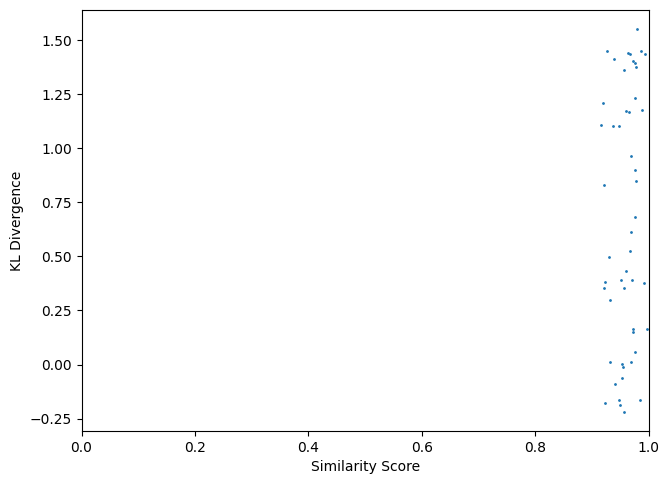

In [ ]:
fig,ax = plt.subplots(1)
fig.tight_layout()

ax.set_xlabel("Similarity Score")
ax.set_ylabel("KL Divergence")
ax.scatter(similarity, kl, s=1)
plt.xlim(0,1)

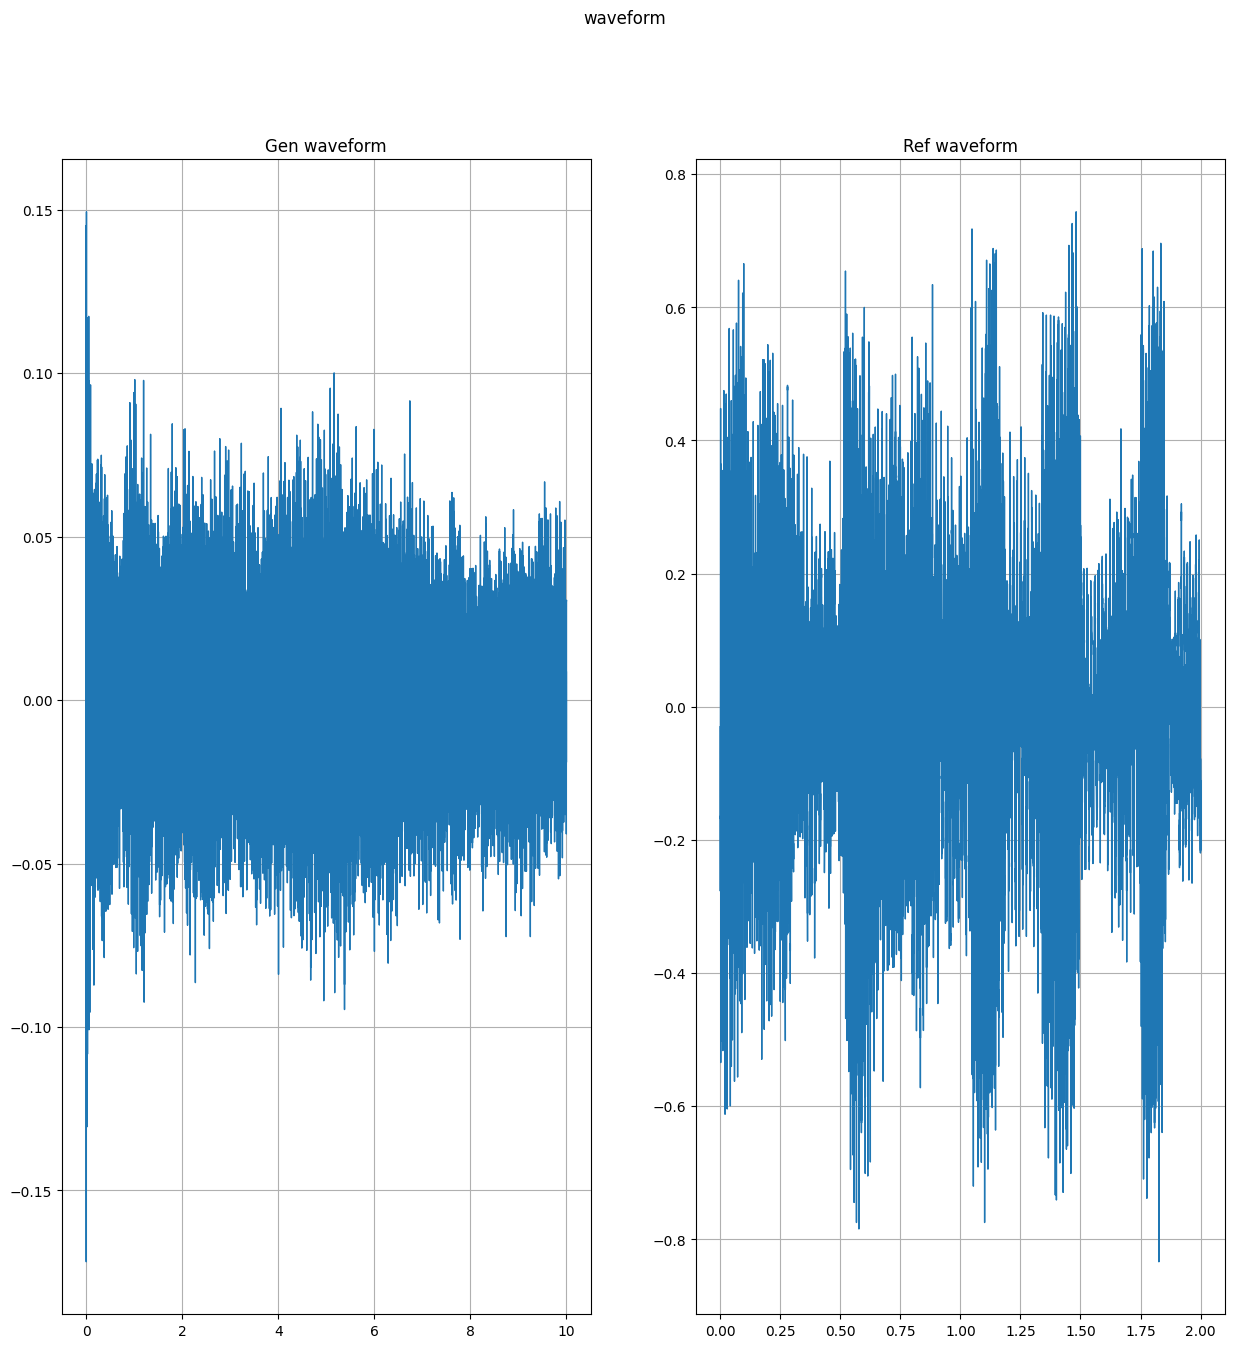

In [ ]:
def load_wave(idx):
    img_name = prompt_df.iloc[idx].painting
    gen_audio_path = f'{gen_audio_dir}/{img_name}.wav'
    gen_waveform, gen_sr = torchaudio.load(gen_audio_path)

    pair_data = pairs_df[pairs_df.IMG_FILE == img_name].sort_values(by=["score", "euclid_dist"],ascending=False).iloc[0]
    ref_audio_path = f'{ref_audio_dir}/{pair_data.WAV_FILE}.wav'
    ref_waveform, ref_sr = torchaudio.load(ref_audio_path)

    return gen_waveform, gen_sr, ref_waveform, ref_sr

def plot_gen_waveform(gen_wave, gen_sr, ref_wave, ref_sr):

    gen_waveform = gen_wave.numpy()
    _, gen_num_frames = gen_waveform.shape

    ref_waveform = ref_wave.numpy()
    _, ref_num_frames = ref_waveform.shape

    gen_time_axis = torch.arange(0, gen_num_frames) / gen_sr
    ref_time_axis = torch.arange(0, ref_num_frames) / ref_sr

    waveform = [gen_waveform, ref_waveform]
    time_axis = [gen_time_axis, ref_time_axis]
    title = ["Gen waveform", "Ref waveform"]

    figure, axes = plt.subplots(1,2, figsize=(15,15))

    for i,wave in enumerate(waveform):
        axes[i].plot(time_axis[i], wave[0], linewidth=1)
        axes[i].grid(True)
        axes[i].set_title(title[i])


    figure.suptitle("waveform")

gen_wave, gen_sr, ref_wave, ref_sr = load_wave(1)
plot_gen_waveform(gen_wave, gen_sr, ref_wave, ref_sr)


##KL Divergence (Random similar)

Plot graph similarity against KL measured

In [ ]:
!pip install datasets

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline, AutoConfig
from transformers.pipelines.pt_utils import KeyDataset
import pandas as pd
from datasets import Dataset, Audio
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

sample_rate = 16000
config = AutoConfig.from_pretrained("SeyedAli/Musical-genres-Classification-Hubert-V1")
idx2label = config.id2label
label2idx = config.label2id
pipe = pipeline("audio-classification", model="SeyedAli/Musical-genres-Classification-Hubert-V1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at SeyedAli/Musical-genres-Classification-Hubert-V1 were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForS

In [ ]:
NEWDSET_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/new_dataset" #Generated audio subdir

pairs_df = pd.read_csv(f'{NEWDSET_PATH}/random_similar_subsample.csv')

In [ ]:
gen_audio_subdir = f'{NEWDSET_PATH}/random_similar_output'
ref_audio_subdir = "/content/drive/MyDrive/Colab Notebooks/Project/IMEMNet/cut_audio"
gen_fnames = os.listdir(gen_audio_subdir)

ref_fnames = []
sim_scores = []
for gen_fname in gen_fnames:
  top_row = pairs_df[pairs_df.IMG_FILE == gen_fname.split(".")[0]].sort_values(by=["score", "euclid_dist"],ascending=False).iloc[0]
  ref_fnames.append(top_row.WAV_FILE)
  sim_scores.append(top_row.score)

ref_audio_paths = list(map(lambda fname : f'{ref_audio_subdir}/{fname}.wav',ref_fnames))
gen_audio_paths = list(map(lambda fname : f'{gen_audio_subdir}/{fname}',gen_fnames))


audio_dataset = Dataset.from_dict(
    {"gen_audio": gen_audio_paths,
     "ref_audio": ref_audio_paths,
     "sim_score": sim_scores
    }).cast_column(
        "gen_audio", Audio(sampling_rate = sample_rate)
    ).cast_column(
        "ref_audio", Audio(sampling_rate = sample_rate)
    )

print(len(audio_dataset))

In [ ]:
def two_second_window(x,sr):
  num_splits = x.size//sr
  idx = np.random.randint(num_splits - 1)
  return x[idx*sr: (idx+2)*sr]

kl = []
similarity = []

kl_total = 0
for input in audio_dataset:
  with torch.no_grad():
    ref_audio = input['ref_audio']['array']
    ref_audio_preprocess = pipe.preprocess(ref_audio)
    ref_audio_logits = pipe._forward(ref_audio_preprocess).logits
    ref_audio_dist = ref_audio_logits.softmax(-1)

    gen_audio = two_second_window(input['gen_audio']['array'], 16000)
    assert(gen_audio.shape == ref_audio.shape)
    gen_audio_preprocess = pipe.preprocess(gen_audio)
    gen_audio_logits = pipe._forward(gen_audio_preprocess).logits
    gen_audio_dist = gen_audio_logits.softmax(-1)

    kl.append(F.kl_div(ref_audio_dist, gen_audio_dist,log_target=True, reduction="batchmean"))
    similarity.append(input['sim_score'])

50


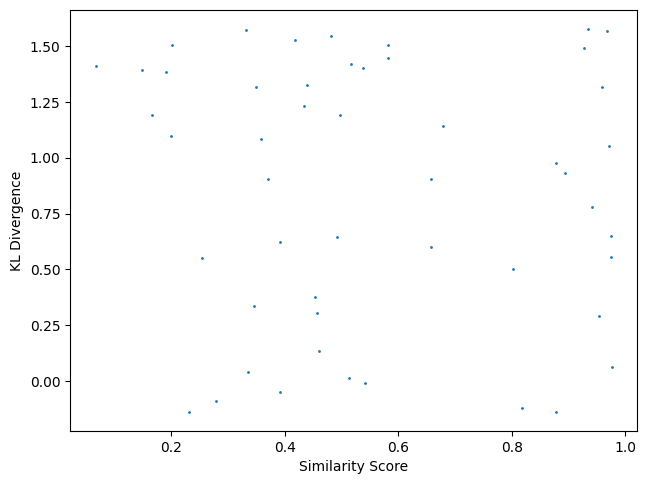

In [ ]:
fig,ax = plt.subplots(1)
fig.tight_layout()

ax.set_xlabel("Similarity Score")
ax.set_ylabel("KL Divergence")
ax.scatter(similarity, kl, s=1)